#### Importing all the required libraries

In [25]:
import itertools
import pickle
import random
import matplotlib
import math
import copy
import cv2
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from imutils import paths
from sklearn.neighbors import NeighborhoodComponentsAnalysis, KNeighborsClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from xgboost import XGBClassifier

from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, plot_precision_recall_curve, plot_confusion_matrix
from sklearn.model_selection import train_test_split
from collections import Counter

In [5]:
pip install python-math

Note: you may need to restart the kernel to use updated packages.


In [10]:
pip install opencv-python

Note: you may need to restart the kernel to use updated packages.


In [15]:
pip install imutils

  Created wheel for imutils: filename=imutils-0.5.4-py3-none-any.whl size=25862 sha256=42e343ca88a20867def71a6d22019a8cb02add86ed7fef903642c887fdd5a68a
  Stored in directory: c:\users\akhil\appdata\local\pip\cache\wheels\86\d7\0a\4923351ed1cec5d5e24c1eaf8905567b02a0343b24aa873df2
Successfully built imutils
Note: you may need to restart the kernel to use updated packages.


#### Reading dataset path and loading images

In [26]:
print("Loading images...")
data = []
labels = []

imagePaths = sorted(list(paths.list_images("data/training")))
random.seed(42)
random.shuffle(imagePaths)

for imagePath in imagePaths:
    image = cv2.imread(imagePath, 0)
    image = cv2.resize(image, (40, 40))
    image = np.reshape(image, 1600)
    data.append(image)

    label = imagePath[-7:-4]
    if label == "pos":
        label = 1
    else:
        label = 0
    labels.append(label)

data = np.array(data, dtype="float") / 255.0
labels = np.array(labels)

Loading images...


#### Displaying array sample

In [27]:
# displaying image array
print(data[:4])

# displaying labels
print(labels[:4])

[[0.01176471 0.07058824 0.09411765 ... 0.11372549 0.10196078 0.11764706]
 [0.68627451 0.68235294 0.74509804 ... 0.11372549 0.12156863 0.09803922]
 [0.16862745 0.20392157 0.29019608 ... 0.19215686 0.06666667 0.20784314]
 [0.22745098 0.24313725 0.28235294 ... 0.19607843 0.14117647 0.11764706]]
[0 0 1 1]


#### Displaying training image

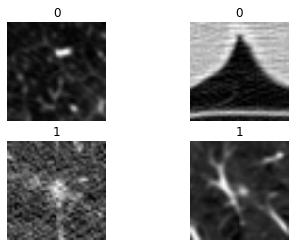

In [28]:
for i, images in enumerate(imagePaths[:4]):
    img = cv2.imread(images)
    img = cv2.resize(img, (100, 100))
    plt.subplot(2, 2, i + 1)
    plt.title(labels[i])
    plt.imshow(img)
    plt.grid(False)
    plt.axis('off')
plt.show()

#### Splitting dataset into train-test

In [29]:
trainX, testX, trainY, testY = train_test_split(data, labels, test_size=0.25, random_state=3)

In [30]:
trainX.shape, testX.shape

((2206, 1600), (736, 1600))

#### NCA-XGBoosting

In [31]:
dim = len(trainX[0])
n_classes = len(np.unique(trainY))

In [32]:
nca = make_pipeline(
    StandardScaler(),
    NeighborhoodComponentsAnalysis(n_components=2, random_state=3),
)

In [33]:
xgb = XGBClassifier(n_estimators=3)

In [34]:
nca.fit(trainX, trainY)

Pipeline(memory=None,
         steps=[('standardscaler',
                 StandardScaler(copy=True, with_mean=True, with_std=True)),
                ('neighborhoodcomponentsanalysis',
                 NeighborhoodComponentsAnalysis(callback=None, init='auto',
                                                max_iter=50, n_components=2,
                                                random_state=3, tol=1e-05,
                                                verbose=0, warm_start=False))],
         verbose=False)

In [35]:
xgb.fit(nca.transform(trainX), trainY)

XGBClassifier(base_score=0.5, booster=None, colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints=None,
              learning_rate=0.300000012, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints=None,
              n_estimators=3, n_jobs=0, num_parallel_tree=1,
              objective='binary:logistic', random_state=0, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=1, subsample=1, tree_method=None,
              validate_parameters=False, verbosity=None)

In [36]:
print("Accuracy score -->" ,accuracy_score(xgb.predict(nca.transform(testX)), testY))

Accuracy score --> 0.7459239130434783


In [37]:
print(classification_report(testY, xgb.predict(nca.transform(testX))))

              precision    recall  f1-score   support

           0       0.71      0.84      0.77       378
           1       0.80      0.64      0.71       358

    accuracy                           0.75       736
   macro avg       0.75      0.74      0.74       736
weighted avg       0.75      0.75      0.74       736



In [38]:
confusion_matrix(testY, xgb.predict(nca.transform(testX)))

array([[319,  59],
       [128, 230]], dtype=int64)

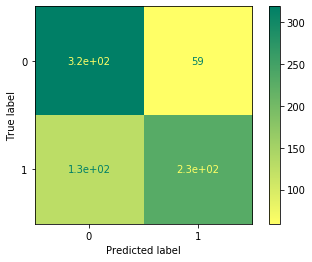

In [39]:
plot_confusion_matrix(estimator=xgb, X=nca.transform(testX), y_true=testY, cmap="summer_r")
plt.show()

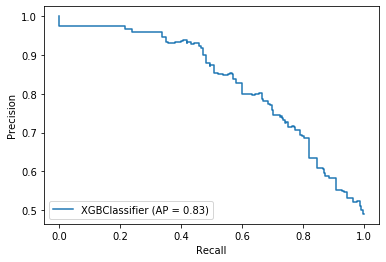

In [40]:
plot_precision_recall_curve(estimator=xgb, X=nca.transform(testX), y=testY)
plt.show()

#### KNN Classifier

In [41]:
knn = KNeighborsClassifier(n_neighbors=5)

In [42]:
knn.fit(trainX, trainY)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=5, p=2,
                     weights='uniform')

In [43]:
print("Accuracy score -->" ,accuracy_score(knn.predict(testX), testY))

Accuracy score --> 0.9171195652173914


In [44]:
print(classification_report(testY, knn.predict(testX)))

              precision    recall  f1-score   support

           0       0.91      0.94      0.92       378
           1       0.93      0.90      0.91       358

    accuracy                           0.92       736
   macro avg       0.92      0.92      0.92       736
weighted avg       0.92      0.92      0.92       736



In [45]:
confusion_matrix(testY, knn.predict(testX))

array([[354,  24],
       [ 37, 321]], dtype=int64)

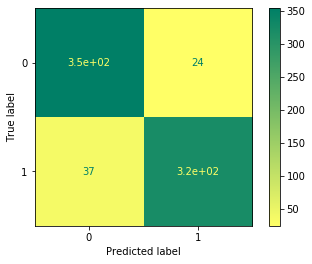

In [46]:
plot_confusion_matrix(estimator=knn, X=testX, y_true=testY, cmap="summer_r")
plt.show()

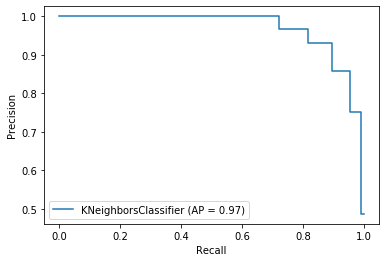

In [47]:
plot_precision_recall_curve(estimator=knn, X=testX, y=testY)
plt.show()

#### Adaboost Classifier

In [48]:
ada = AdaBoostClassifier(n_estimators=50,
                         learning_rate=1.0,
                         algorithm='SAMME.R')

In [49]:
ada.fit(trainX, trainY)

AdaBoostClassifier(algorithm='SAMME.R', base_estimator=None, learning_rate=1.0,
                   n_estimators=50, random_state=None)

In [50]:
print("Accuracy score -->" ,accuracy_score(ada.predict(testX), testY))

Accuracy score --> 0.8627717391304348


In [51]:
print(classification_report(testY, ada.predict(testX)))

              precision    recall  f1-score   support

           0       0.85      0.88      0.87       378
           1       0.87      0.84      0.86       358

    accuracy                           0.86       736
   macro avg       0.86      0.86      0.86       736
weighted avg       0.86      0.86      0.86       736



In [52]:
confusion_matrix(testY, ada.predict(testX))

array([[334,  44],
       [ 57, 301]], dtype=int64)

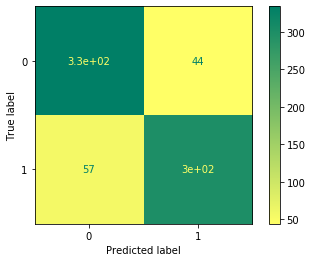

In [53]:
plot_confusion_matrix(estimator=ada, X=testX, y_true=testY, cmap="summer_r")
plt.show()

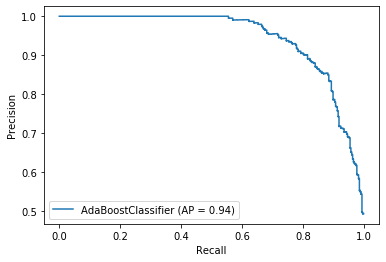

In [54]:
plot_precision_recall_curve(estimator=ada, X=testX, y=testY)
plt.show()